В этом ноутбуке получим красивые примеры картинок - предсказаний.

Нужно:

- получить красивую картинку (картинка - объеты - точка - вероятности) без учёта углов
- то же самое с учётом углов, но только перед этим заиметь некрасивую картинку в одном случае и красивую в новом
- целый пайплайн предсказания и несколько удачных и неудачных примеров

In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs, draw_all_rectangles
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

from utils import read_pickle, dump_pickle

In [3]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [4]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
rectangled_predicts_folder = 'rectangled_predicts_pixel'
objects_predicts_folder = 'rectangled_predicts_obj'

osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [5]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [6]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 616


In [7]:
def get_all_tags(img_osm_object):
    return [o.tag for o in img_osm_object.osm_objects if o.tag != 'ridge' and o.tag != 'valley' ]

In [8]:
result_ids = []

i = 0

bad_count_before_100 = 0
bad_count_after_100 = 0

while len(result_ids) < 100:
    img_id = test_ids[i]
    
    try:
        img_osm_object = read_pickle(os.path.join(osm_objects_path, img_id + '.pickle'))
    except Exception as e:
        print(e)
        # Дальше, чем 100, предсказаний нет
        break
    tags = get_all_tags(img_osm_object)
    
    if len(tags) < 2:
        print(f"{i}:, image: {img_id}, tags: {tags}")
        if i < 100:
            bad_count_before_100 += 1
        else:
            bad_count_after_100 += 1
    else:
        result_ids.append(img_id)
        
    i += 1

1:, image: 9501, tags: []
4:, image: 10196, tags: []
6:, image: 11093, tags: []
7:, image: 11980, tags: []
10:, image: 11410, tags: []
11:, image: 16382, tags: []
13:, image: 9437, tags: []
15:, image: 1006, tags: []
16:, image: 3800, tags: []
18:, image: 16832, tags: ['water']
20:, image: 18649, tags: []
23:, image: 16577, tags: []
24:, image: 14357, tags: []
25:, image: 14705, tags: []
26:, image: 17506, tags: []
27:, image: 14406, tags: []
29:, image: 9463, tags: []
30:, image: 14706, tags: []
33:, image: 18004, tags: []
34:, image: 4221, tags: []
36:, image: 21615, tags: []
38:, image: 11947, tags: []
39:, image: 16286, tags: []
43:, image: 21799, tags: []
44:, image: 13603, tags: []
46:, image: 1869, tags: []
47:, image: 11859, tags: ['water']
48:, image: 202, tags: []
50:, image: 18478, tags: []
55:, image: 12939, tags: []
56:, image: 18421, tags: []
57:, image: 8750, tags: []
58:, image: 14014, tags: []
59:, image: 20030, tags: ['peak']
60:, image: 19572, tags: []
61:, image: 13

In [9]:
print(len(result_ids))

42


In [10]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [11]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [12]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [13]:
def calculate_precision_k_for_one(img_id, max_k):
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [14]:
%%time
is_in_k = []

for img_id in result_ids:
    
    is_in_k += calculate_precision_k_for_one(img_id, max_k=1)
    
    if len(is_in_k) % 200 == 0:
        print(len(is_in_k))
        

200


../utils.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
CPU times: user 13min 33s, sys: 318 ms, total: 13min 33s
Wall time: 13min 33s


In [14]:
def get_all_objects_and_tags(img_osm_object):
    return [(o.tag, o.minlon, o.maxlat, o.maxlon, o.minlat) 
            for o in img_osm_object.osm_objects if o.tag != 'ridge' and o.tag != 'valley' ]

In [15]:
def calculate_cell_probs_for_all_points(img_id):
    point_to_probs = []
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        point_to_probs.append((agent_point, cell_probs))
        
    return point_to_probs

In [27]:
%%time
points_to_probs = {}

for img_id in result_ids:
    print(img_id)
    points_to_probs[img_id] = calculate_cell_probs_for_all_points(img_id)

20327
3138
7130


../utils.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


10798
15300
14346
2041
14119
224
14651
1903
84
6482
3995
1901
11199
2293
2903
14793
6036
10818
5304
6413
3595
1102
12843
3079
18344
5465
16906
5887
14806
2342
14776
7496
7126
9820
14428
20893
19024
4037
5157
CPU times: user 13min 36s, sys: 1.64 s, total: 13min 38s
Wall time: 13min 38s


In [31]:
filename_pickle = img_id + '.pickle'
    
img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [32]:
is_in_k = np.array(is_in_k)

In [33]:
imgs_acc = []
is_in_1 = []

for i in range(len(result_ids)):
    local_is_in_1 = is_in_k[i * 100 : i * 100 + 100, 0]
    acc = local_is_in_1.sum() / 100
    imgs_acc.append(acc)
    is_in_1.append(local_is_in_1)


In [16]:
# Теперь как стало
from circle_diagram import calculate_penalty_for_diagrams

In [17]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
#         penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [18]:
def calculate_precision_k_for_one(img_id, max_k):
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)
#         agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [40]:
%%time
is_in_k_2 = []

for img_id in result_ids:
    
    is_in_k_2 += calculate_precision_k_for_one(img_id, max_k=1)
    
    if len(is_in_k_2) % 200 == 0:
        print(len(is_in_k_2))
        

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
CPU times: user 2min 45s, sys: 308 ms, total: 2min 45s
Wall time: 2min 45s


In [41]:
is_in_k_2 = np.array(is_in_k_2)

In [42]:
imgs_acc_2 = []
is_in_1_2 = []

for i in range(len(result_ids)):
    local_is_in_1 = is_in_k_2[i * 100 : i * 100 + 100, 0]
    acc = local_is_in_1.sum() / 100
    imgs_acc_2.append(acc)
    is_in_1_2.append(local_is_in_1)


In [19]:
def calculate_cell_probs_for_all_points_2(img_id):
    point_to_probs = []
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False,
                                      with_angle_penalty=True)
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        point_to_probs.append((agent_point, cell_probs))
        
    return point_to_probs

In [44]:
%%time
points_to_probs_2 = {}

for img_id in result_ids:
    print(img_id)
    points_to_probs_2[img_id] = calculate_cell_probs_for_all_points_2(img_id)

20327
3138
7130
10798
15300
14346
2041
14119
224
14651
1903
84
6482
3995
1901
11199
2293
2903
14793
6036
10818
5304
6413
3595
1102
12843
3079
18344
5465
16906
5887
14806
2342
14776
7496
7126
9820
14428
20893
19024
4037
5157
CPU times: user 2min 49s, sys: 220 ms, total: 2min 49s
Wall time: 2min 49s


In [54]:
def show_img(img_id, img_acc, img_acc_2, is_in_1_list, is_in_1_list_2):
    print(f"ACCURACY BEFORE: {img_acc}")
    print(f"ACCURACY AFTER: {img_acc_2}")
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(121)
    img = cv2.imread('../dataset/satellite/' + img_id + '.png')
    plt.title('Original image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    img_osm = read_pickle(os.path.join(osm_objects_path, img_id + '.pickle'))
    
    tags = get_all_tags(img_osm)
    
    print(tags)

    objects_and_tags = get_all_objects_and_tags(img_osm)
    
    img_copy = img.copy()
    
    for obj_type, x_min, y_min, x_max, y_max in objects_and_tags:
        if obj_type == 'wood':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        if obj_type == 'water':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
        if obj_type == 'peak':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 255), thickness=2)

    plt.subplot(122)
    plt.title('Predicted objects')
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.show()
                          
    
    ### Сырые маски
    
    raw_predicts_folder = os.path.join(predictions_folder, 'raw_predicts_img')
    numpy_filename = img_id + '.npy'
    raw_wood = np.load(os.path.join(raw_predicts_folder, 'wood', numpy_filename))
    raw_water = np.load(os.path.join(raw_predicts_folder, 'water', numpy_filename))
    raw_peak = np.load(os.path.join(raw_predicts_folder, 'peak', numpy_filename))
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(131)
    plt.imshow(raw_wood.reshape(raw_wood.shape[:2]))
    plt.title('Wood mask')
    
    plt.subplot(132)
    plt.imshow(raw_water.reshape(raw_water.shape[:2]))
    plt.title('Water mask')
    
    plt.subplot(133)
    plt.imshow(raw_peak.reshape(raw_peak.shape[:2]))
    plt.title('Peaks mask')
    
    plt.show()

    # Результаты нескольких предсказаний
    
    bigger_side = 400
    bigger_side_blocks_count = 8
    one_block_len = bigger_side / bigger_side_blocks_count
    half = one_block_len / 2
    
    point_to_probs_1 = points_to_probs[img_id]
    point_to_probs_2 = points_to_probs_2[img_id]
    
    def _show_results(i):
        img_copy_copy = img_copy.copy()
            
        point = point_to_probs_1[i][0]
        center_point = points_to_centers_6_8[point[::-1]][::-1]

        cv2.circle(img_copy_copy, (point[1], point[0]), 3, (0, 0, 255), -1) 
        cv2.rectangle(img_copy_copy,
             (int(center_point[1] - half), int(center_point[0] - half)),
             (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)

        plt.figure(figsize=(18, 9))
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(img_copy_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"Point: {point_to_probs_1[i][0]}")

        probs = np.array(point_to_probs_1[i][1])
        max_proba_point_id = np.argmax(probs)
        print("Max proba point id 1:", max_proba_point_id)
        max_center_point = img_cds.center_points[max_proba_point_id]
    
        probs = probs.reshape((6, 8))
        probs_img_1 = np.repeat(np.repeat(probs,
                                one_block_len
                                , axis=0),
                      one_block_len,
                      axis=1).reshape(img.shape[:2])
        points_color = np.min(probs_img_1)
        cv2.rectangle(probs_img_1,
             (int(max_center_point[1] - half), int(max_center_point[0] - half)),
             (int(max_center_point[1] + half), int(max_center_point[0] + half)), points_color, 2)
        cv2.circle(probs_img_1, (point[1], point[0]), 3, points_color, -1)

        plt.subplot(132)
        plt.title("Confidences before")
        plt.imshow(probs_img_1)
        
        probs = np.array(point_to_probs_2[i][1])
        max_proba_point_id = np.argmax(probs)
        print("Max proba point id 2:", max_proba_point_id)
        max_center_point = img_cds.center_points[max_proba_point_id]
    
        probs = probs.reshape((6, 8))
        probs_img_2 = np.repeat(np.repeat(probs,
                                one_block_len
                                , axis=0),
                      one_block_len,
                      axis=1).reshape(img.shape[:2])
        points_color = np.min(probs_img_2)
        cv2.rectangle(probs_img_2,
             (int(max_center_point[1] - half), int(max_center_point[0] - half)),
             (int(max_center_point[1] + half), int(max_center_point[0] + half)), points_color, 2)
        cv2.circle(probs_img_2, (point[1], point[0]), 3, points_color, -1)
        
        plt.subplot(133)
        plt.title("Confidences after")
        plt.imshow(probs_img_2)
        
        plt.show()
        
    print("BECOME BETTER")
    good_predictions_counter = 0
    for i in range(len(point_to_probs_1)):
        if is_in_1_list_2[i] and not is_in_1_list[i]:
            _show_results(i)
            
            good_predictions_counter += 1
            if good_predictions_counter == 10:
                break

ACCURACY BEFORE: 0.5
ACCURACY AFTER: 0.55
['wood', 'wood', 'water']


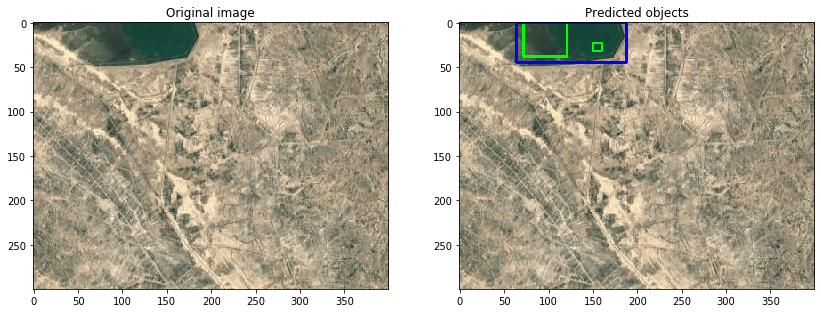

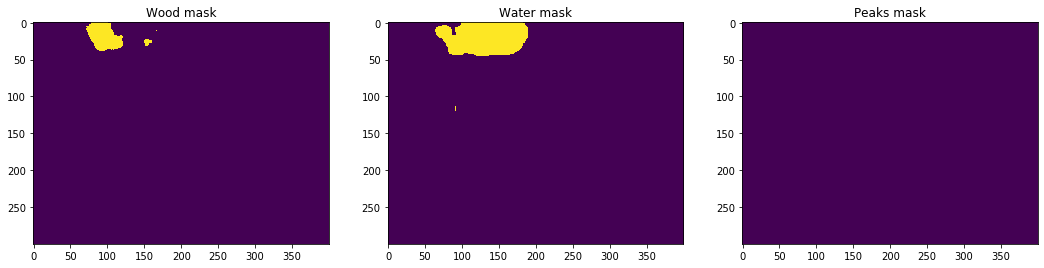

BECOME BETTER
Max proba point id 1: 1
Max proba point id 2: 2


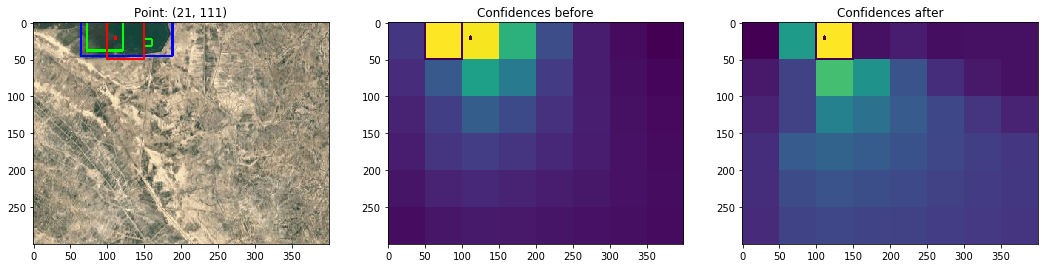

Max proba point id 1: 19
Max proba point id 2: 12


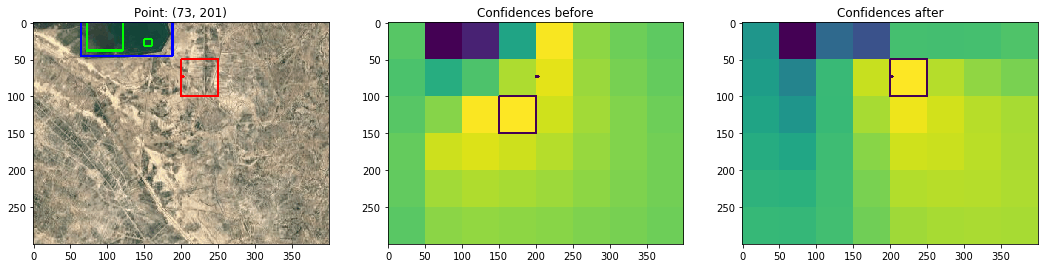

Max proba point id 1: 23
Max proba point id 2: 31


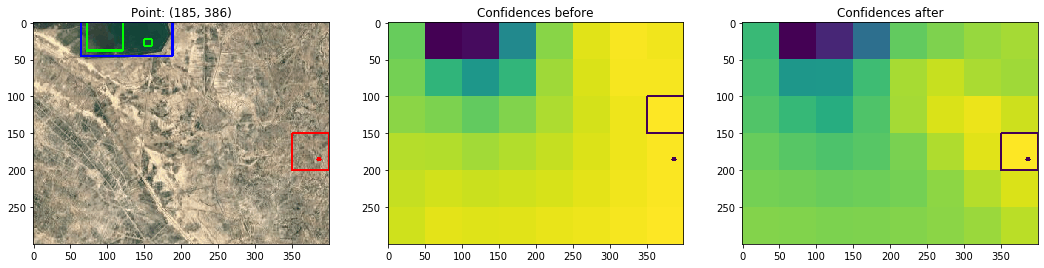

Max proba point id 1: 43
Max proba point id 2: 42


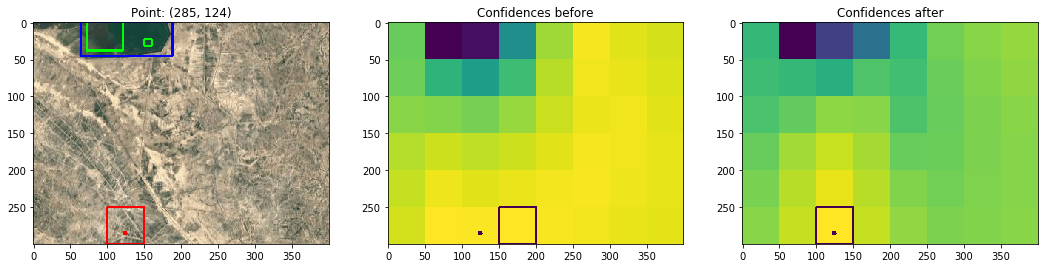

Max proba point id 1: 16
Max proba point id 2: 8


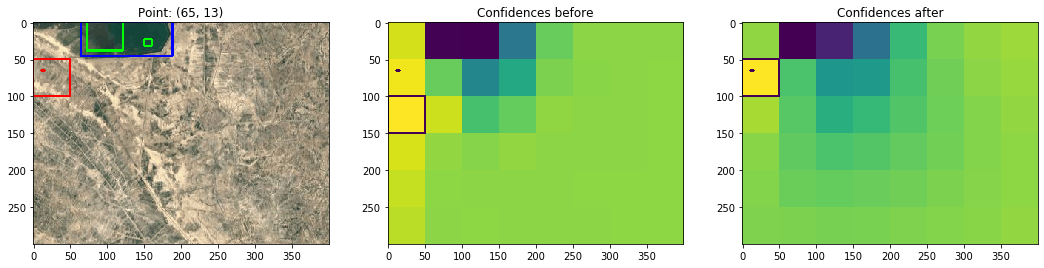

Max proba point id 1: 14
Max proba point id 2: 31


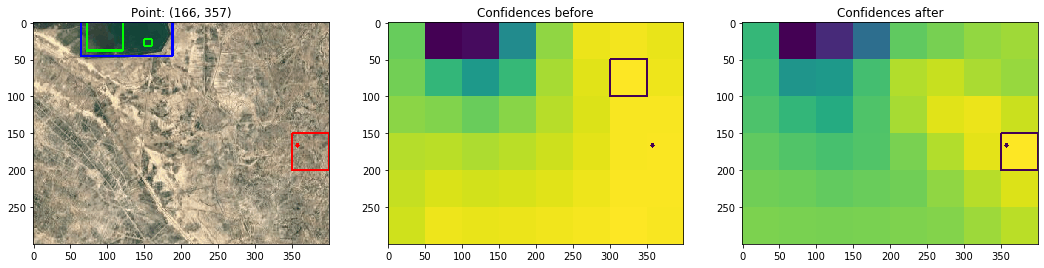

Max proba point id 1: 33
Max proba point id 2: 36


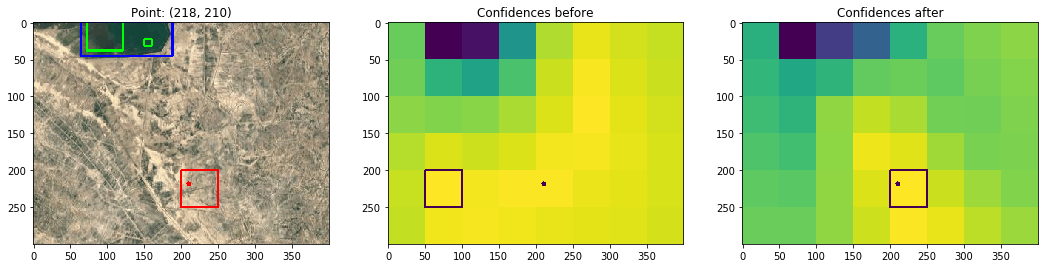

Max proba point id 1: 11
Max proba point id 2: 4


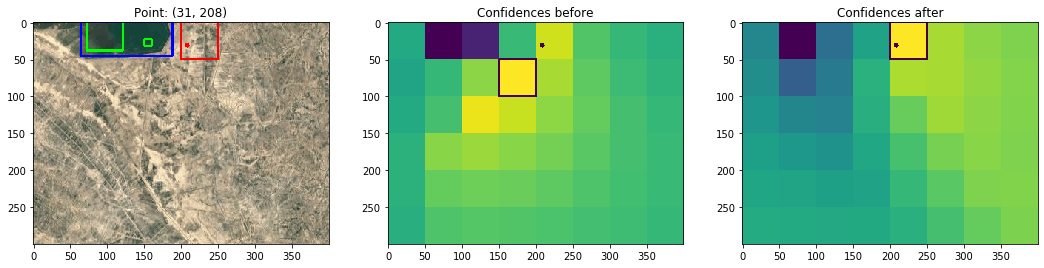

Max proba point id 1: 7
Max proba point id 2: 15


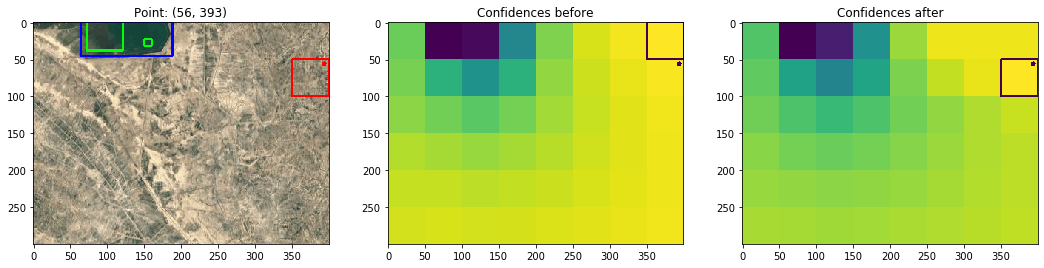

Max proba point id 1: 8
Max proba point id 2: 0


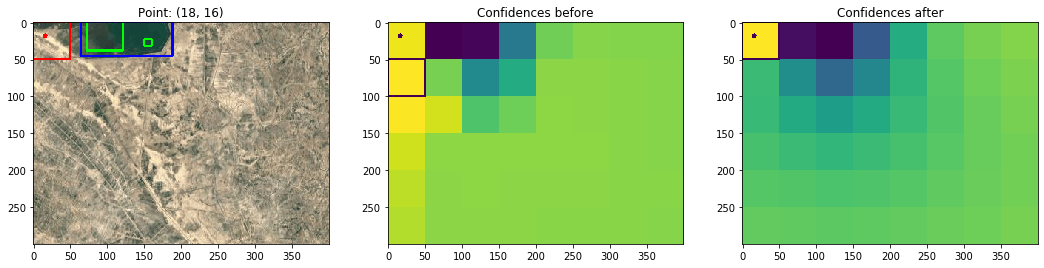

In [55]:
show_img(result_ids[0], imgs_acc[0], imgs_acc_2[0], is_in_1[0], is_in_1_2[0])

ACCURACY BEFORE: 0.63
ACCURACY AFTER: 0.67
['wood', 'wood', 'water', 'water']


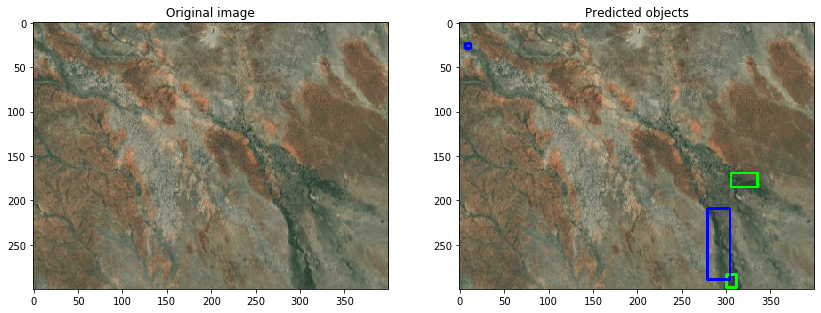

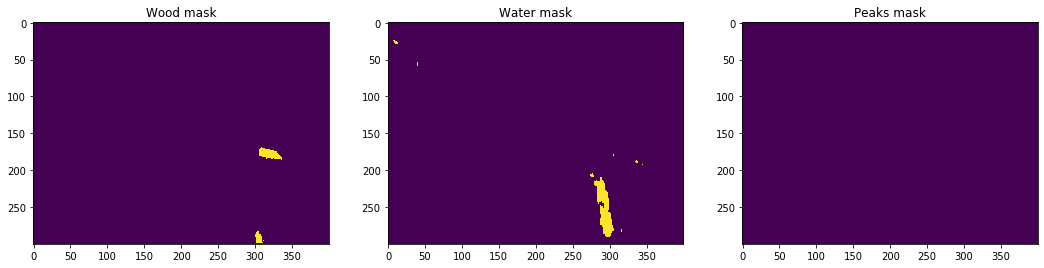

BECOME BETTER
Max proba point id 1: 40
Max proba point id 2: 15


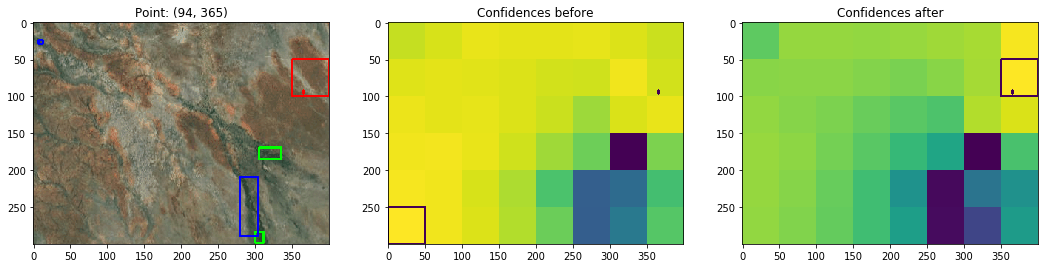

Max proba point id 1: 36
Max proba point id 2: 46


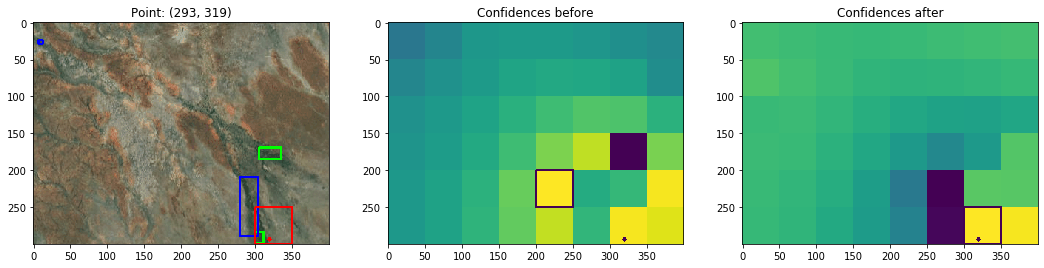

Max proba point id 1: 47
Max proba point id 2: 39


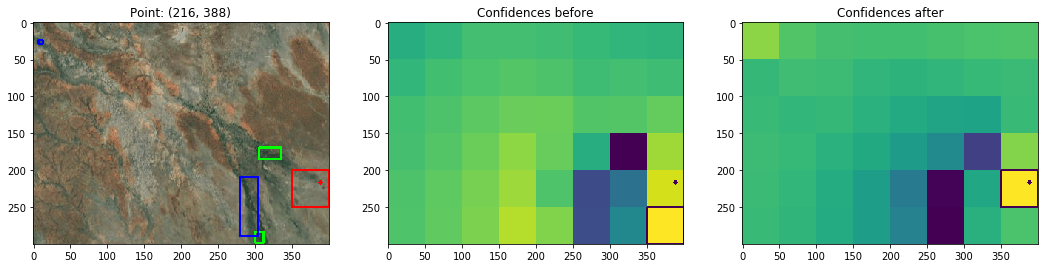

Max proba point id 1: 5
Max proba point id 2: 6


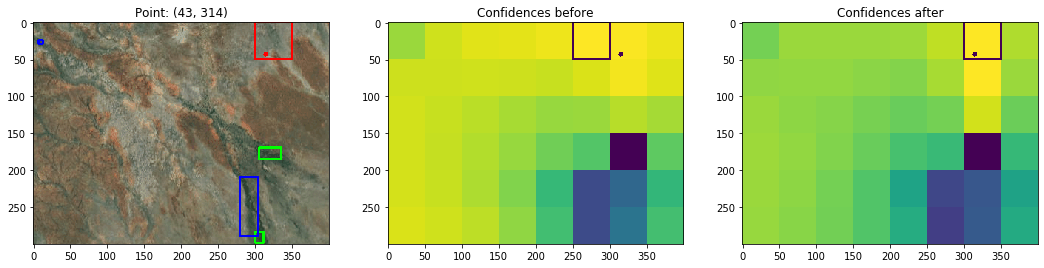

Max proba point id 1: 31
Max proba point id 2: 47


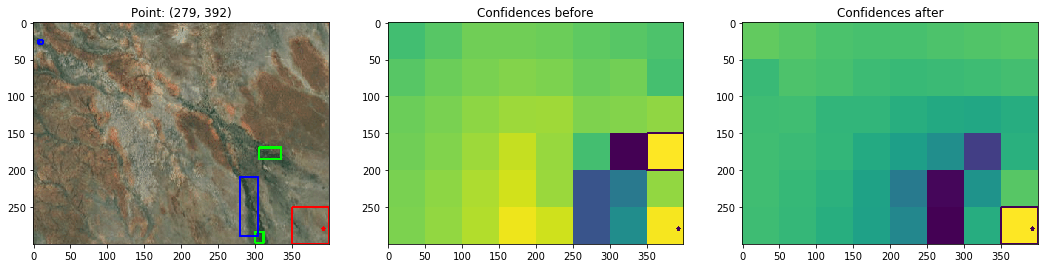

Max proba point id 1: 31
Max proba point id 2: 47


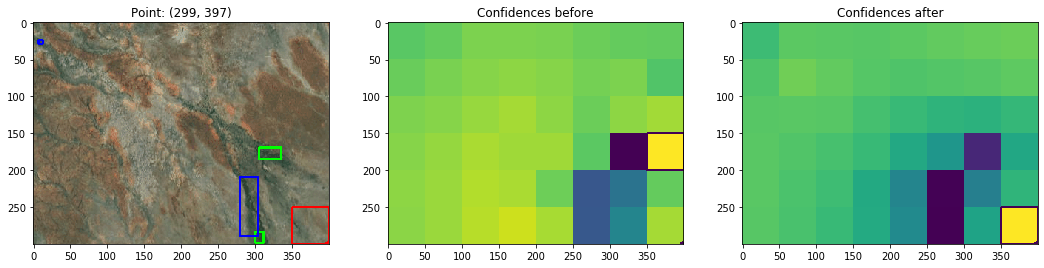

Max proba point id 1: 16
Max proba point id 2: 8


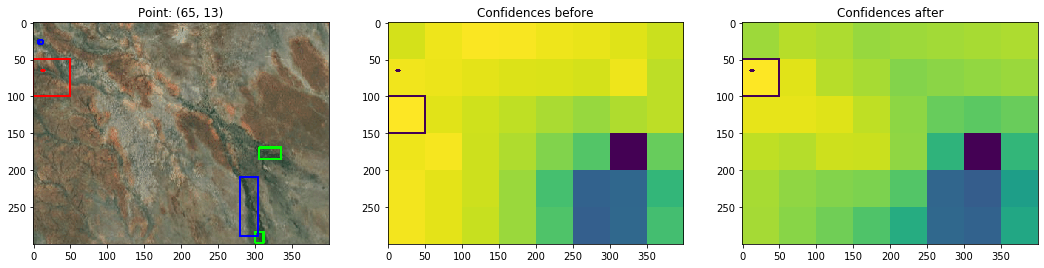

Max proba point id 1: 28
Max proba point id 2: 36


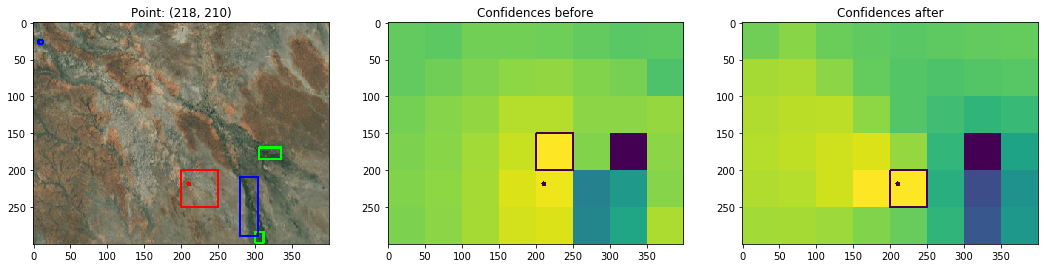

Max proba point id 1: 47
Max proba point id 2: 39


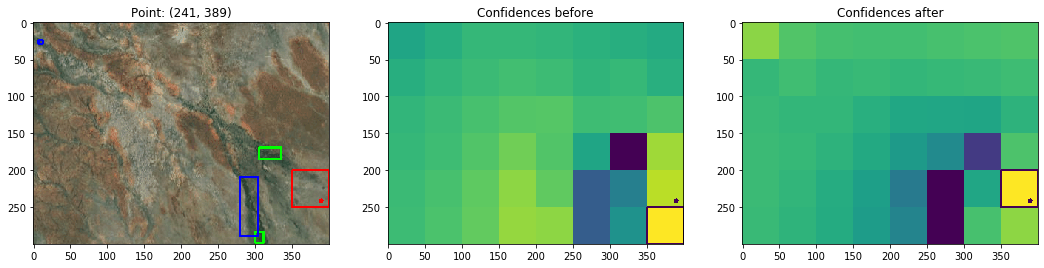

Max proba point id 1: 32
Max proba point id 2: 32


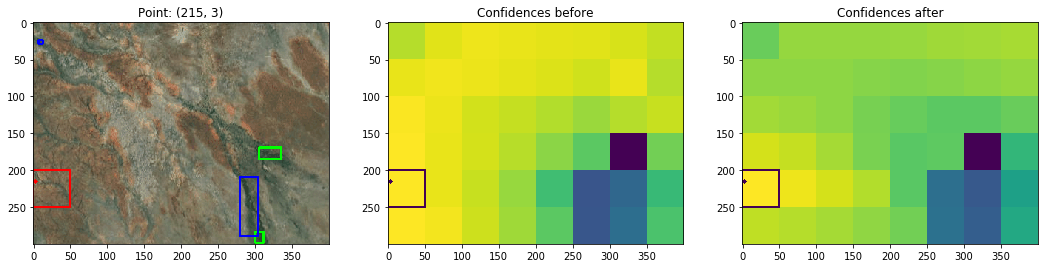

In [56]:
show_img(result_ids[24], imgs_acc[24], imgs_acc_2[24], is_in_1[24], is_in_1_2[24])

ACCURACY BEFORE: 0.5
ACCURACY AFTER: 0.55
['wood', 'water', 'water', 'water', 'water']


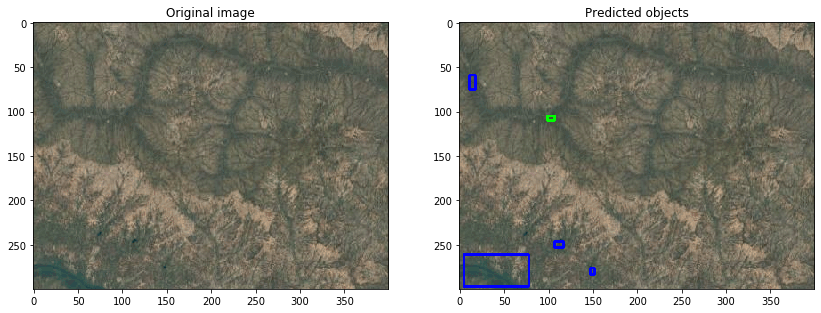

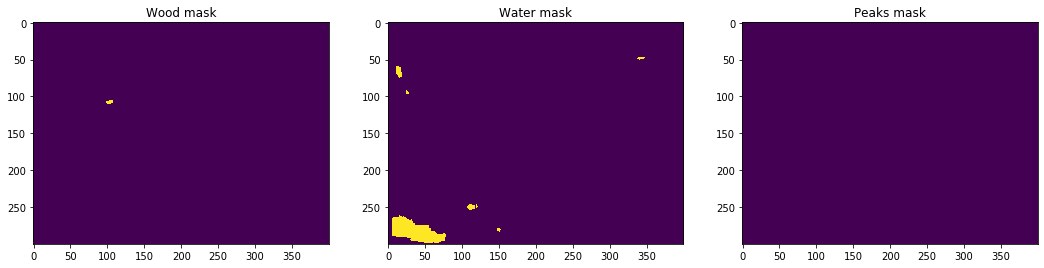

BECOME BETTER
Max proba point id 1: 12
Max proba point id 2: 12


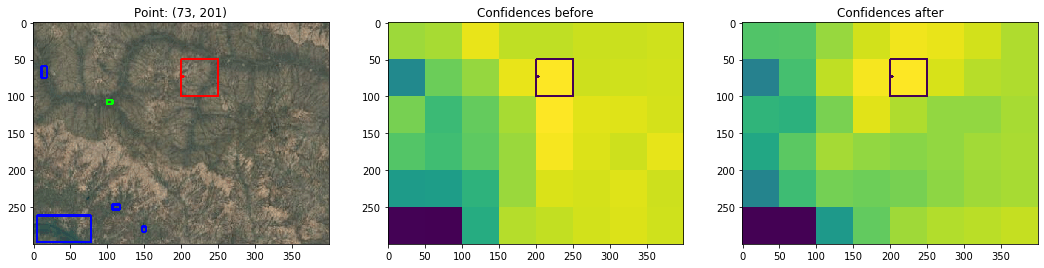

Max proba point id 1: 12
Max proba point id 2: 20


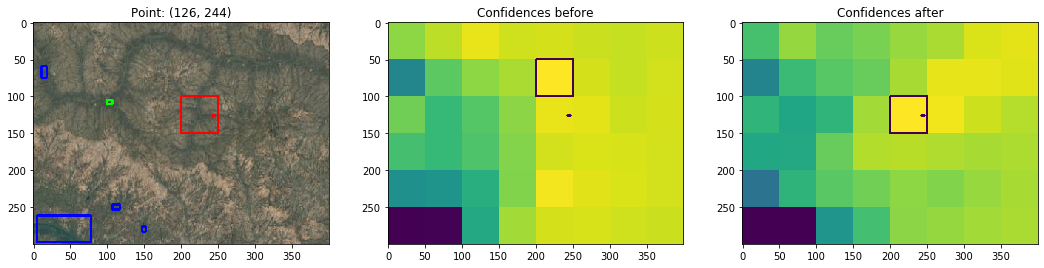

Max proba point id 1: 14
Max proba point id 2: 6


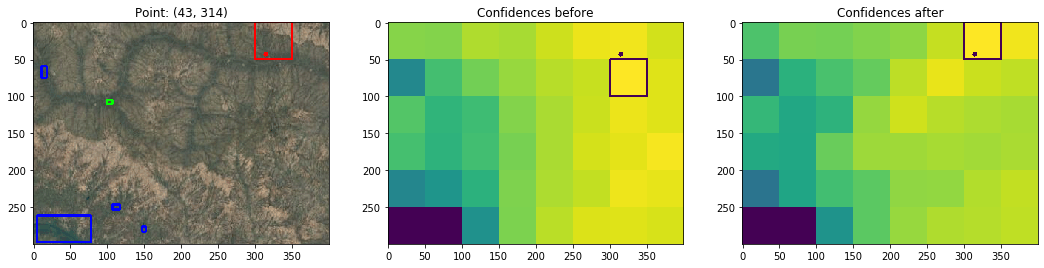

Max proba point id 1: 0
Max proba point id 2: 17


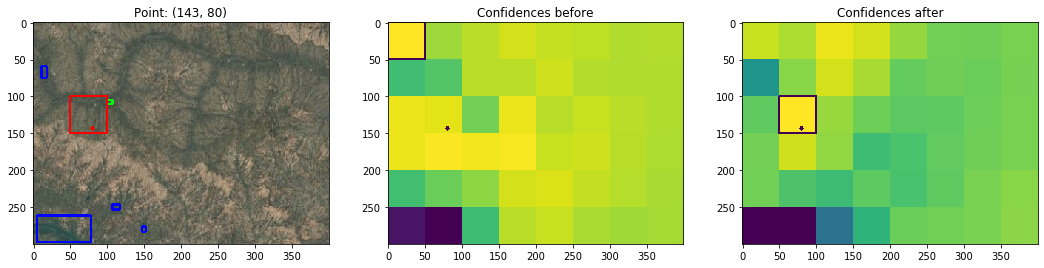

Max proba point id 1: 26
Max proba point id 2: 18


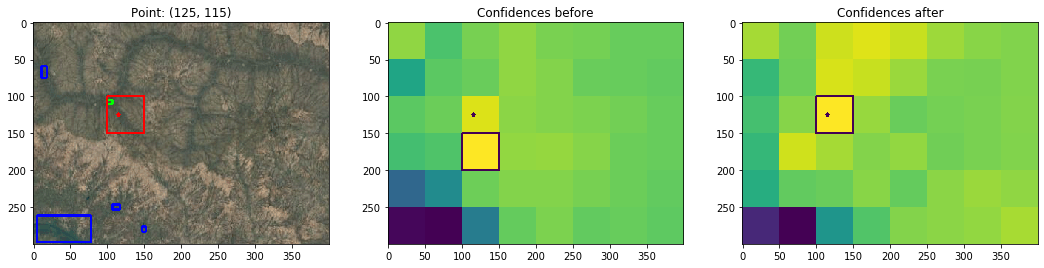

Max proba point id 1: 20
Max proba point id 2: 3


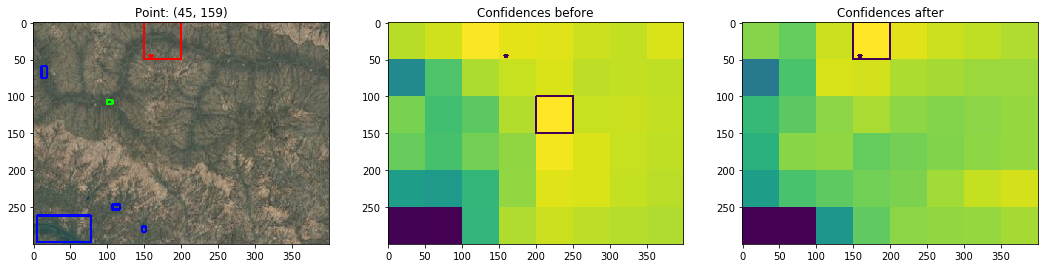

Max proba point id 1: 27
Max proba point id 2: 19


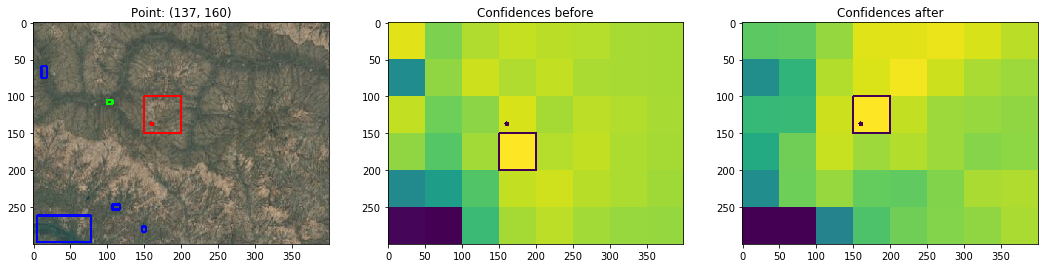

Max proba point id 1: 7
Max proba point id 2: 15


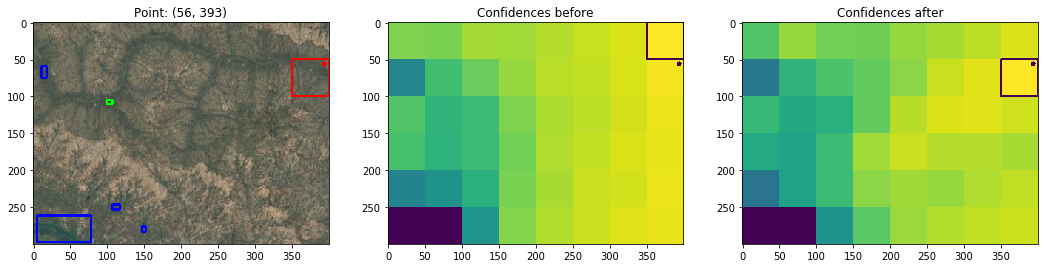

Max proba point id 1: 7
Max proba point id 2: 39


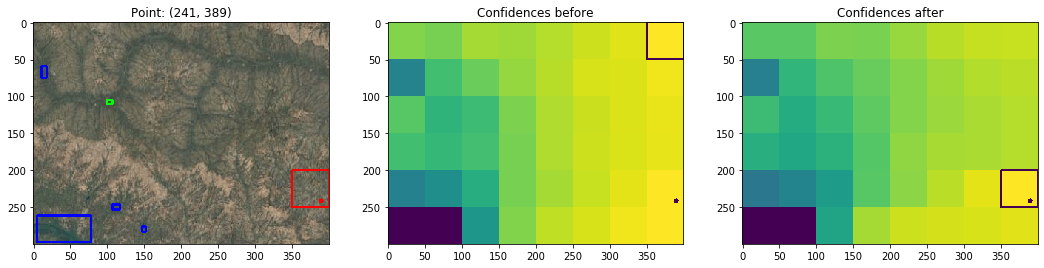

Max proba point id 1: 34
Max proba point id 2: 32


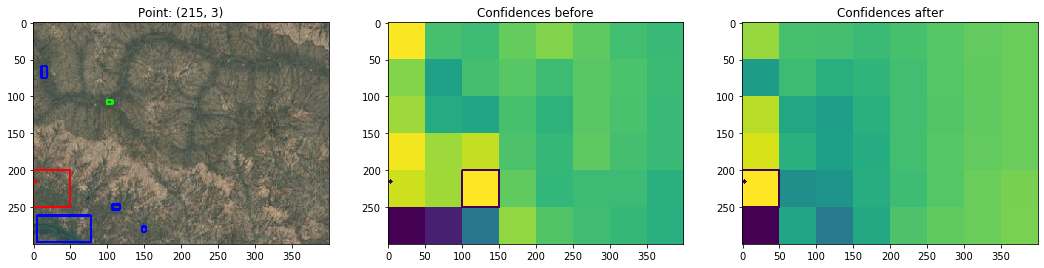

In [57]:
show_img(result_ids[36], imgs_acc[36], imgs_acc_2[36], is_in_1[36], is_in_1_2[36])

ACCURACY BEFORE: 0.49
ACCURACY AFTER: 0.65
['wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood']


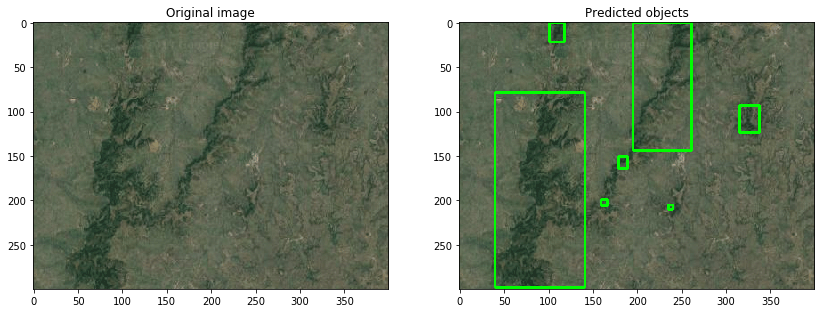

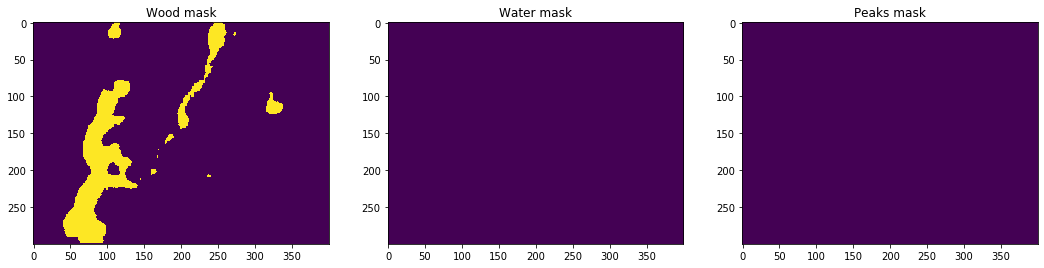

BECOME BETTER
Max proba point id 1: 28
Max proba point id 2: 1


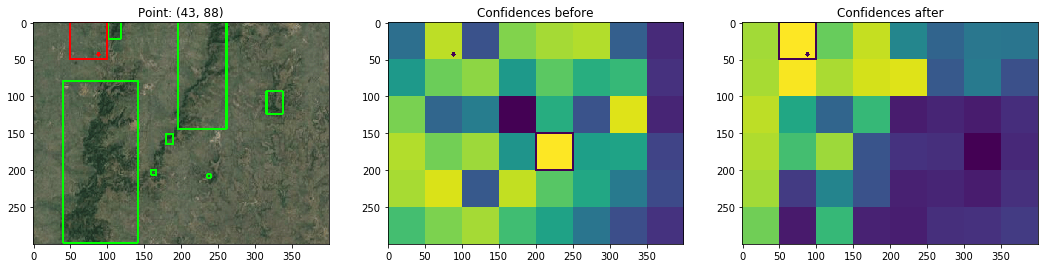

Max proba point id 1: 40
Max proba point id 2: 42


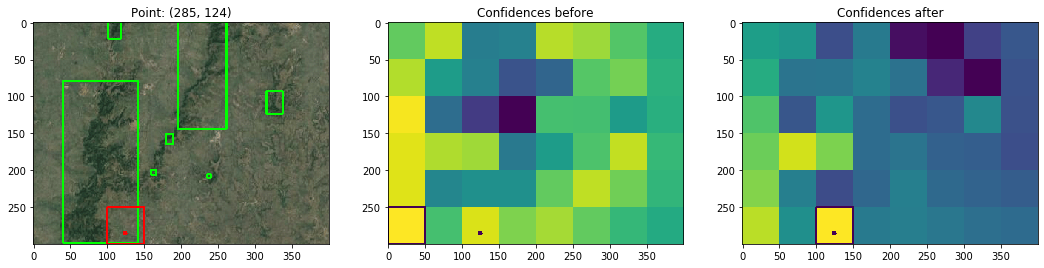

Max proba point id 1: 0
Max proba point id 2: 6


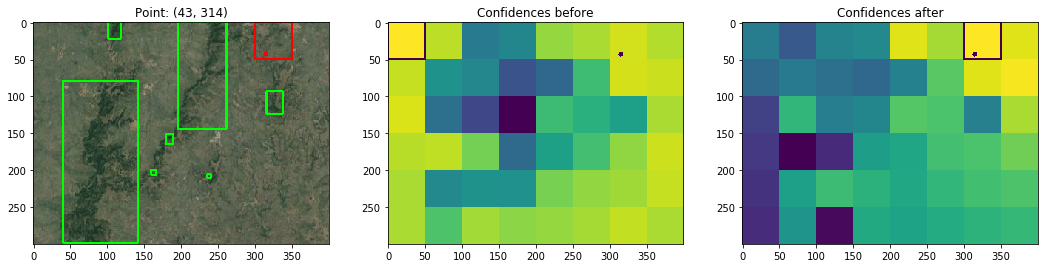

Max proba point id 1: 38
Max proba point id 2: 45


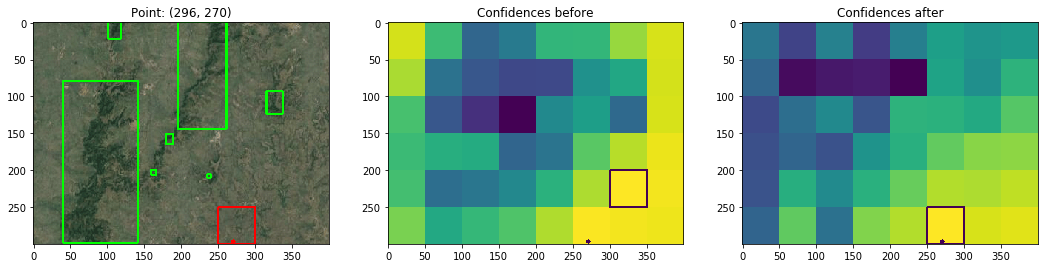

Max proba point id 1: 46
Max proba point id 2: 38


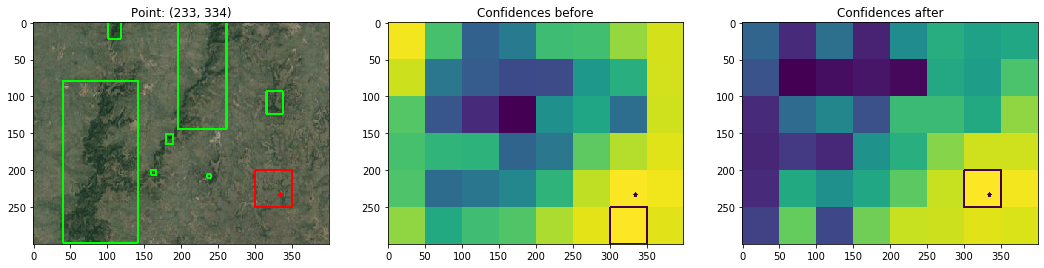

Max proba point id 1: 0
Max proba point id 2: 31


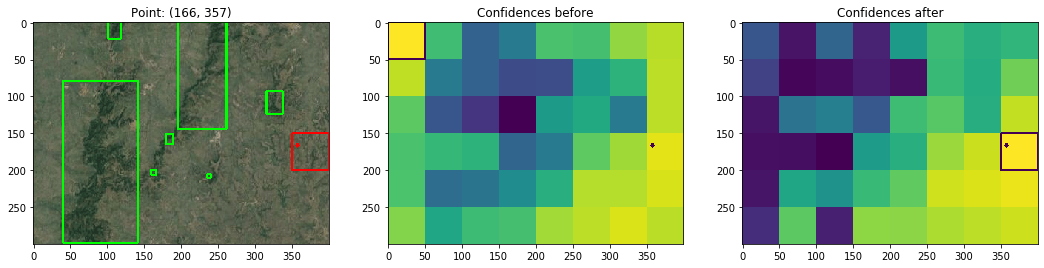

Max proba point id 1: 33
Max proba point id 2: 36


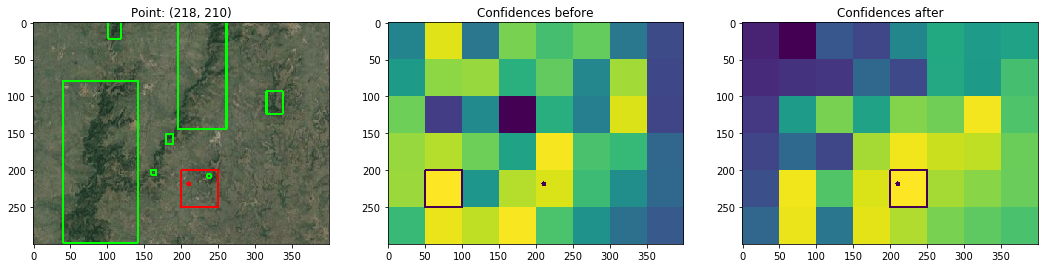

Max proba point id 1: 7
Max proba point id 2: 15


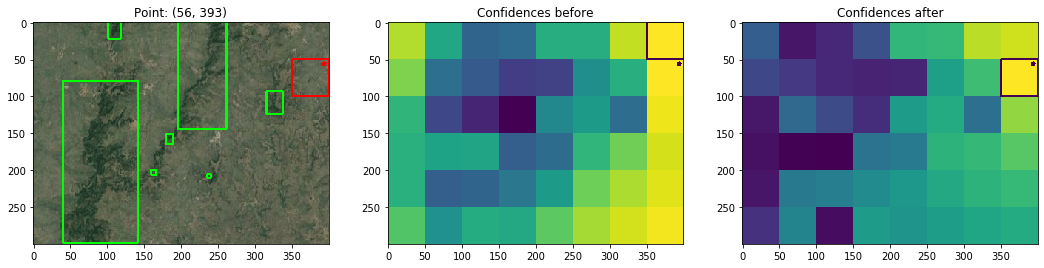

Max proba point id 1: 47
Max proba point id 2: 39


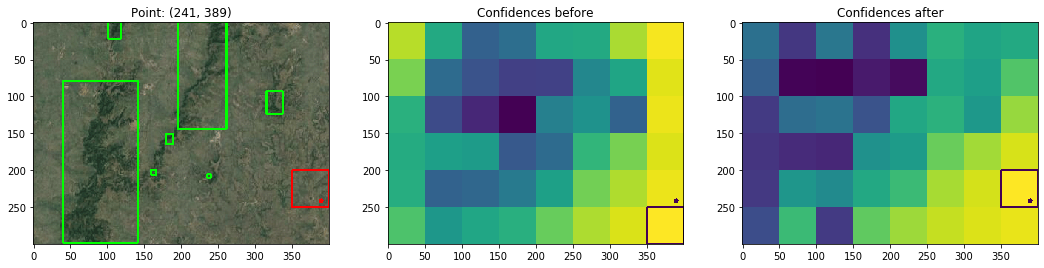

Max proba point id 1: 40
Max proba point id 2: 32


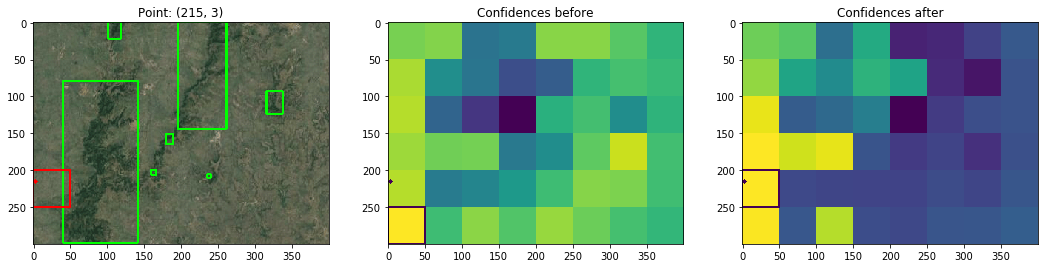

In [58]:
show_img(result_ids[5], imgs_acc[5], imgs_acc_2[5], is_in_1[5], is_in_1_2[5])

ACCURACY BEFORE: 0.55
ACCURACY AFTER: 0.66
['wood', 'wood', 'wood', 'wood', 'wood', 'wood']


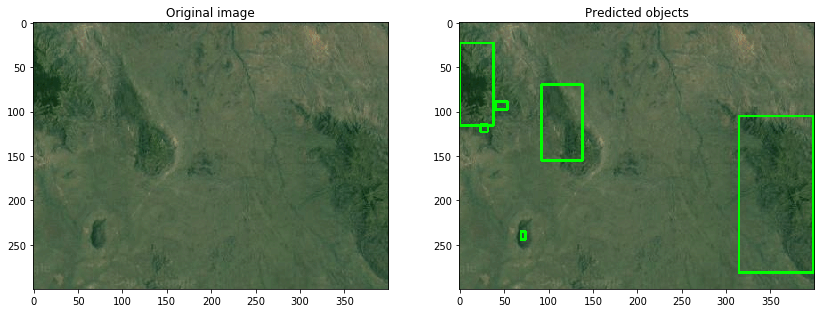

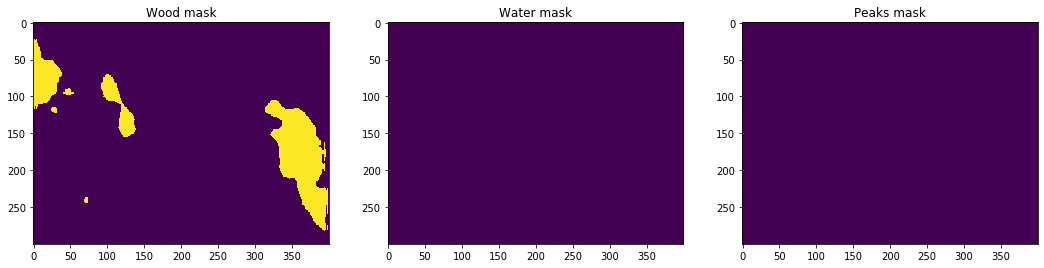

BECOME BETTER
Max proba point id 1: 22
Max proba point id 2: 38


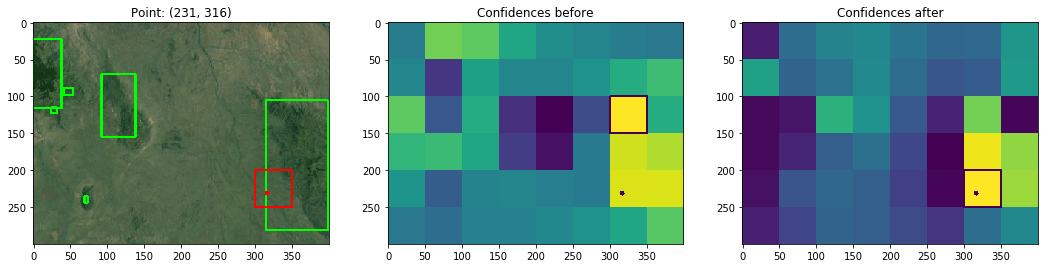

Max proba point id 1: 38
Max proba point id 2: 2


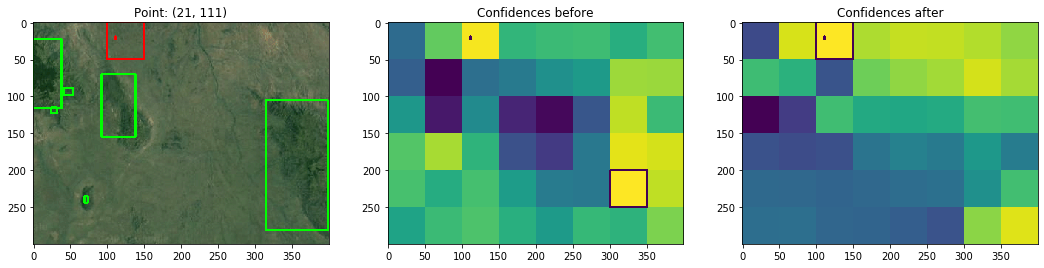

Max proba point id 1: 9
Max proba point id 2: 17


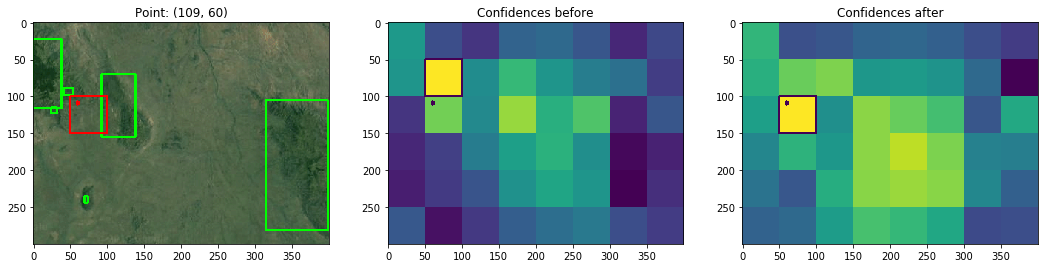

Max proba point id 1: 5
Max proba point id 2: 6


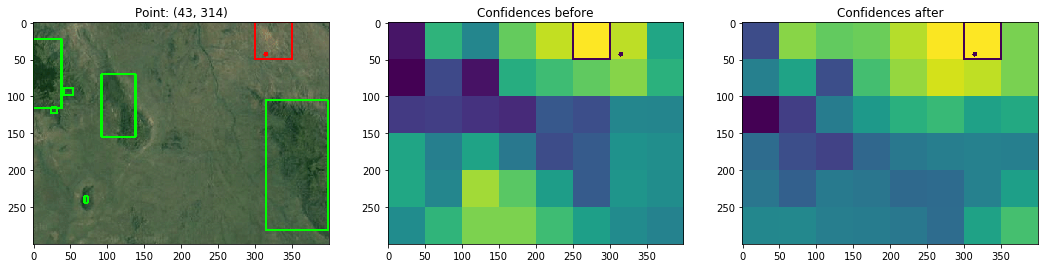

Max proba point id 1: 44
Max proba point id 2: 45


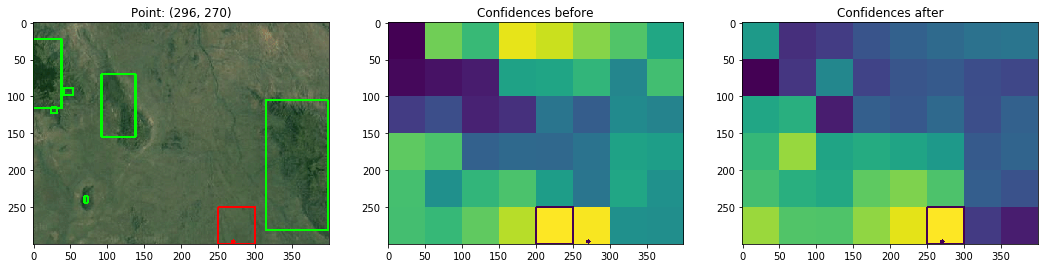

Max proba point id 1: 40
Max proba point id 2: 15


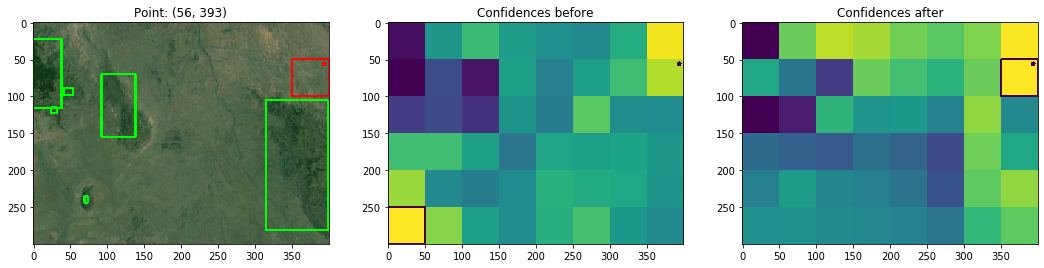

Max proba point id 1: 40
Max proba point id 2: 32


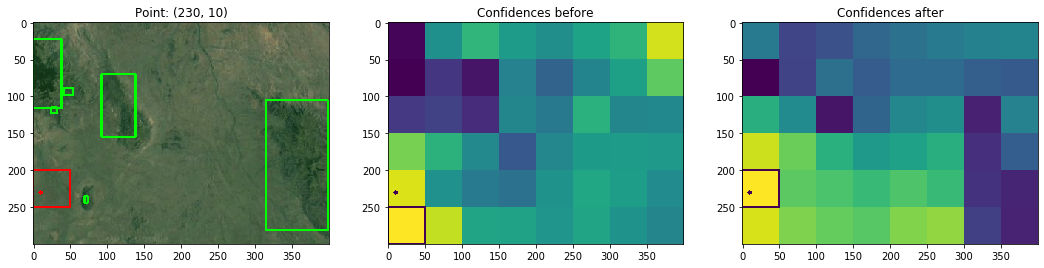

Max proba point id 1: 30
Max proba point id 2: 16


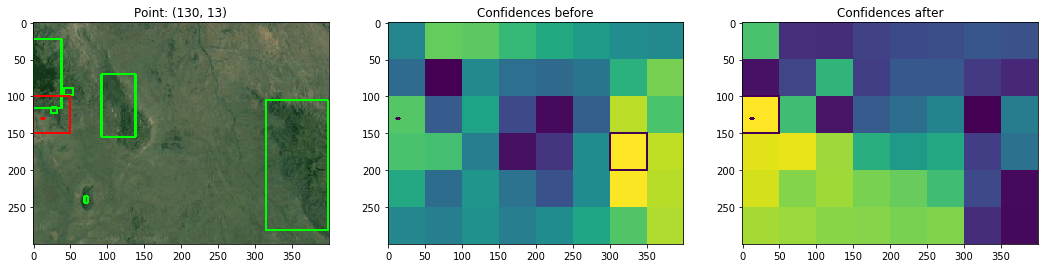

Max proba point id 1: 4
Max proba point id 2: 35


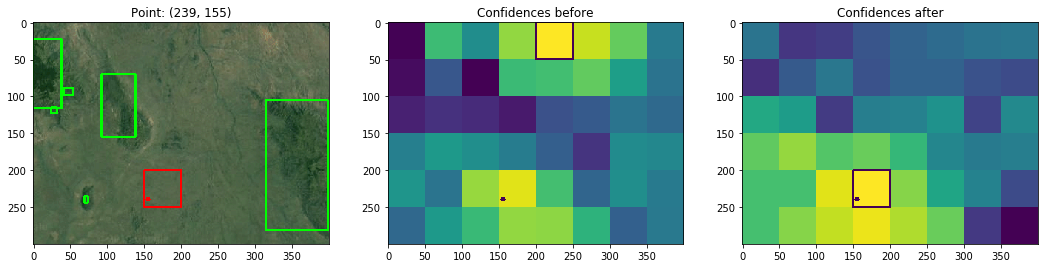

Max proba point id 1: 27
Max proba point id 2: 12


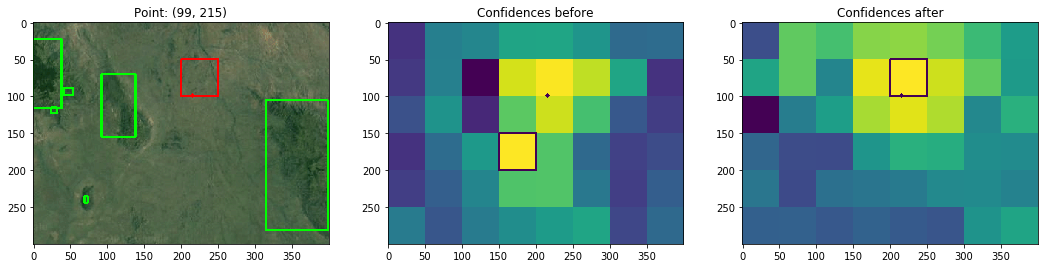

In [59]:
show_img(result_ids[10], imgs_acc[10], imgs_acc_2[10], is_in_1[10], is_in_1_2[10])